# Main Code

In [ ]:
!pip install POT
!pip install unbalancedgw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import pickle
import os
from os.path import dirname
import numpy as np
import scipy
import json

import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [ ]:
import ot

from ot.bregman import sinkhorn
from ot.backend import get_backend

from ot.gromov import init_matrix, list_to_array, gwggrad, gwloss
from ot.gromov import update_square_loss, update_kl_loss
from ot.gromov import gromov_wasserstein

from ot.utils import list_to_array
from ot.utils import check_random_state
from ot.utils import dist

## Utils

### General

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def save_object(obj, file_name):
    # CREATE DIRECTORY IF NOT EXIST
    curr_dir = dirname(file_name)
    create_directory(curr_dir)

    with open(file_name, "wb") as file_out:
        pickle.dump(obj, file_out, pickle.HIGHEST_PROTOCOL)

def read_object(file_name):
    with open(file_name, "rb") as file_in:
        return pickle.load(file_in)

def print_dict(x):
    print(json.dumps(x, sort_keys=True, indent=4))

### Maths

In [ ]:
def sampling_wishart(V, n):
    d = V.shape[0]
    X = [np.random.multivariate_normal(mean=np.zeros(d), cov=V) for _ in range(n)]
    X = np.array(X).T
    
    return X @ X.T

def inner_product_distance(X, Y):
    XX = np.einsum('ij,ij->i', X, X)[:, np.newaxis]
    YY = np.einsum('ij,ij->i', Y, Y)[np.newaxis, :]
    distances = np.dot(X, Y.T)    
    return distances

def compute_log(X, epsilon=1e-16):
    if isinstance(X, np.ndarray):
        return np.log(np.maximum(X, 0) + epsilon)
    elif isinstance(X, torch.Tensor):          
        return torch.log(torch.max(X, torch.tensor(0.0).double().cuda()) + epsilon)
    else:
        raise NotImplementedError

def compute_generalized_entropy(P):
    logP = compute_log(P)        

    if isinstance(P, np.ndarray):
        return -1 * np.sum(logP * P - P)
    elif isinstance(P, torch.Tensor):
        return -1 * torch.sum(logP * P - P)
    else:
        raise NotImplementedError
    
def compute_generalized_KL(p, q):
    log_ratio = compute_log(p) - compute_log(q)

    if isinstance(p, np.ndarray):
        return np.sum(p * log_ratio - p + q)
    elif isinstance(p, torch.Tensor):
        return torch.sum(p * log_ratio - p + q)
    else:
        raise NotImplementedError

def compute_Gaussian_entropy(mu, Sigma):
    d = mu.shape[0]
    return d/2 * (1 + np.log(2 * np.pi)) + 1/2 * np.abs(np.linalg.det(Sigma))

def compute_Gaussians_KL(mu1, Sigma1, mu2, Sigma2):
    d = mu1.shape[0]
    det1 = np.linalg.det(Sigma1)
    det2 = np.linalg.det(Sigma2)
    InvSigma2 = np.linalg.inv(Sigma2)
    return 1/2 * (np.log(det2) - np.log(det1) - d + np.trace(InvSigma2 @ Sigma1) + (mu2 - mu1).T @ InvSigma2 @ (mu2 - mu1))

In [ ]:
def is_psd(A):
    return np.all(np.linalg.eigvals(A) >= 0)

### Curve Fitting

In [ ]:
from scipy import optimize

In [ ]:
def fitgaussian(data):
    points, values = data
    p0 = (1, 0, 1)

    def errorfunction(p):
        a, b, c = p
        B = np.array([[a**2, 0], [b, c**2]])
        current_values = scipy.stats.multivariate_normal.pdf(points, np.zeros(2), B @ B.T).reshape(-1)
        current_values = current_values / current_values.sum()

        return current_values - values.reshape(-1)
    
    p, success = optimize.leastsq(errorfunction, p0)
    print(success)
    return p

## Balanced IGW

### Theory

In [ ]:
def compute_entropic_igw_formula(SigmaX, SigmaY, epsilon):
    dX, dY = SigmaX.shape[0], SigmaY.shape[0]
    d = min(dX, dY)

    diagX, diagY = np.diagonal(SigmaX), np.diagonal(SigmaY)
    diagX_sorted = np.flip(np.sort(diagX))[:d]
    diagY_sorted = np.flip(np.sort(diagY))[:d]

    kappa = np.maximum(1 - epsilon / (4 * (diagX_sorted * diagY_sorted)), 0)

    part1 = np.sum(diagX**2) + np.sum(diagY**2)    
    part2 = 2 * np.sum(diagX_sorted * diagY_sorted * kappa)
    part3 = -epsilon/2 * np.sum(np.log(1 - kappa))    
    
    return part1 - part2 + part3

def compute_entropic_igw_formula_2(SigmaX, SigmaY, epsilon):
    dX, dY = SigmaX.shape[0], SigmaY.shape[0]
    d = min(dX, dY)

    diagX, diagY = np.diagonal(SigmaX), np.diagonal(SigmaY)
    diagX_sorted = np.flip(np.sort(diagX))[:d]
    diagY_sorted = np.flip(np.sort(diagY))[:d]    

    part1 = np.sum(diagX**2) + np.sum(diagY**2)    
    part2 = 2 * np.sum(np.maximum(diagX_sorted * diagY_sorted - epsilon / 4, np.zeros(1)))
    part3 = epsilon/2 * np.sum(np.maximum(np.log(diagX_sorted * diagY_sorted) - np.log(epsilon/4), np.zeros(1)))
    
    return part1 - part2 + part3    

def get_optimal_plan(SigmaX, SigmaY, epsilon):
    dX, dY = SigmaX.shape[0], SigmaY.shape[0]
    d = min(dX, dY)

    diagX, diagY = np.diagonal(SigmaX), np.diagonal(SigmaY)
    diagX_sorted = np.flip(np.sort(diagX))[:d]
    diagY_sorted = np.flip(np.sort(diagY))[:d]

    kappa = np.maximum(1 - epsilon / (4 * (diagX_sorted * diagY_sorted)), 0)
    Kappa = np.diag(np.sqrt(diagX_sorted * diagY_sorted * kappa))
    Kappa_extended = np.zeros(shape=(dX, dY))
    Kappa_extended[:d, :d] = Kappa

    Sigma_upper = np.concatenate([SigmaX, Kappa_extended], axis=1)
    Sigma_lower = np.concatenate([Kappa_extended.T, SigmaY], axis=1)
    Sigma = np.concatenate([Sigma_upper, Sigma_lower], axis=0)
    
    return np.zeros(shape=(dX + dY,)), Sigma

def compute_igw(muX, muY, Sigma, epsilon):
    dX = muX.shape[0]
    dY = muY.shape[0]
    SigmaX = Sigma[:dX, :dX]
    SigmaY = Sigma[dX:, dX:]
    K = Sigma[:dX, dX:]

    Sigma_XY = np.zeros(shape=(dX + dY, dX + dY))
    Sigma_XY[:dX, :dX] = SigmaX
    Sigma_XY[dX:, dX:] = SigmaY

    part1 = np.trace(SigmaX**2) + np.trace(SigmaY**2)
    part2 = 2 * np.trace(K.T @ K)
    part3 = epsilon * compute_Gaussians_KL(np.concatenate([muX, muY], axis=-1), Sigma,
                                             np.concatenate([muX, muY], axis=-1), Sigma_XY)    
     
    return part1 - part2 + part3

### Approximation

In [ ]:
# Credit: https://pythonot.github.io/index.html

def entropic_gromov_wasserstein(C1, C2, p, q, loss_fun, epsilon, max_iter=1000, tol=1e-9, verbose=False, log=False):
    C1, C2, p, q = list_to_array(C1, C2, p, q)
    nx = get_backend(C1, C2, p, q)

    # T = nx.outer(p, q)    
    T = torch.rand(p.shape[0], q.shape[0]).double().cuda()
    T = T / T.sum()

    constC, hC1, hC2 = init_matrix(C1, C2, p, q, loss_fun)

    cpt = 0
    err = 1

    if log:
        log = {'err': []}

    while (err > tol and cpt < max_iter):

        Tprev = T

        # compute the gradient
        tens = gwggrad(constC, hC1, hC2, T)        

        # print(np.amin(tens), np.amax(tens))
        T = sinkhorn(p, q, tens, epsilon, method='sinkhorn_log', numItermax=10000)  # [sinkhorn | sinkhorn_log | sinkhorn_stabilized]

        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = nx.norm(T - Tprev)

            if log:
                log['err'].append(err)

            if verbose:
                if cpt % 200 == 0:
                    print('{:5s}|{:12s}'.format(
                        'It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    if log:
        log['gw_dist'] = gwloss(constC, hC1, hC2, T)        
        log['gw_dist_with_entropy'] = log['gw_dist'] + epsilon * compute_generalized_KL(T, p.reshape(-1, 1) @ q.reshape(-1, 1).T)
        log['constC'] = constC
        log['hC1'] = hC1
        log['hC2'] = hC2
        return T, log
    else:
        return T

In [ ]:
def rounding(P, r, c):
    r = r.reshape(-1, 1)
    c = c.reshape(-1, 1)

    rP = P.sum(axis=1).reshape(-1, 1)
    P = np.diag(np.minimum(r / rP, np.ones_like(rP)).reshape(-1,)) @ P

    cP = P.sum(axis=0).reshape(-1, 1)    
    P = P @ np.diag(np.minimum(c / cP, np.ones_like(cP)).reshape(-1,))

    err_rP = r - P.sum(axis=1).reshape(-1, 1)
    err_cP = c - P.sum(axis=0).reshape(-1, 1)

    return P + err_rP @ err_cP.T / np.sum(np.abs(err_rP))

## Unbalanced IGW

In [ ]:
def ReLU(x):
    return max(x, 0)


def KL(x, y):
    return x * np.log(x / y) - x + y


def solve_uigw(mX, mY, lambdaX, lambdaY, tau, eps):
    dX, dY = lambdaX.shape[0], lambdaY.shape[0]
    d = min(dX, dY)

    Gamma, varphi, phi = compute_Gamma(lambdaX, lambdaY, tau, eps)
    mP = (mX * mY) ** ((tau + eps) / (2 * tau + eps)) * np.exp(-Gamma / (2 * (2 * tau + eps)))

    objective = mP ** 2 * Gamma + eps * KL(mP ** 2, mX ** 2 * mY ** 2) + tau * (KL(mP ** 2, mX ** 2) + KL(mP ** 2, mY ** 2))
    
    SigmaX = np.diag(varphi)
    SigmaY = np.diag(phi)
    psi = np.sqrt(np.maximum(1 - eps / (2 * varphi[:dY] * phi), 0) * varphi[:dY] * phi)
    Psi = np.diag(psi)
    Psi_extended = np.zeros(shape=(dX, dY))
    Psi_extended[:d, :d] = Psi

    Sigma_upper = np.concatenate([SigmaX, Psi_extended], axis=1)
    Sigma_lower = np.concatenate([Psi_extended.T, SigmaY], axis=1)
    Sigma = np.concatenate([Sigma_upper, Sigma_lower], axis=0)    
    plan = (np.zeros(shape=(dX + dY,)), Sigma)

    return objective, plan


def compute_g(x, y, a, b, tau, eps):
    return x ** 2 + y ** 2 + eps * ReLU(np.log(x * y) - np.log(eps / 2)) + (tau + eps) * (x / a + y / b - np.log((x * y) / (a * b)) - 2) - 2 * ReLU(x * y - eps / 2)


def compute_g1(x, y, a, b, tau, eps):
    return x ** 2 + y ** 2 + (tau + eps) * (x / a + y / b - np.log((x * y) / (a * b)) - 2)


def compute_g2(x, y, a, b, tau, eps):
    return x ** 2 + y ** 2 + eps * (np.log(x * y) - np.log(eps / 2)) + (tau + eps) * (x / a + y / b - np.log((x * y) / (a * b)) - 2) - 2 * (x * y - eps / 2)


def compute_h(x, a, tau, eps):
    return x ** 2 + (tau + eps) * (x / a - np.log(x / a) - 1)


def optimize_g(a, b, tau, eps):
    xtilde, ytilde = optimize_g1(a, b, tau, eps)

    if xtilde * ytilde < eps / 2:
        return compute_g(xtilde, ytilde, a, b, tau, eps), (xtilde, ytilde)
    else:
        xhat, yhat = optimize_g2(a, b, tau, eps)
        return compute_g(xhat, yhat, a, b, tau, eps), (xhat, yhat)


def optimize_g1(a, b, tau, eps):
    xtilde = - (tau + eps) / (4 * a) + 1 / 2 * np.sqrt(2 * (tau + eps) + (tau + eps) ** 2 / (4 * a ** 2))
    ytilde = - (tau + eps) / (4 * b) + 1 / 2 * np.sqrt(2 * (tau + eps) + (tau + eps) ** 2 / (4 * b ** 2))
    return xtilde, ytilde


def optimize_g2(a, b, tau, eps):
    z = np.amax(np.roots([tau, (8 * tau - (tau + eps) ** 2 / (a * b)), 16 * tau - 2 * (tau + eps) ** 2 * (1 / a + 1 / b) ** 2, -4 * (tau + eps) ** 2 * (1 / a + 1 / b) ** 2]))
    xhat = - (tau + eps) / (4 * a) + 1 / 2 * np.sqrt((tau + eps) ** 2 / (4 * a ** 2) + 4 * tau * (1 / 2 + 1 / z))
    yhat = - (tau + eps) / (4 * b) + 1 / 2 * np.sqrt((tau + eps) ** 2 / (4 * b ** 2) + 4 * tau * (1 / 2 + 1 / z))
    return xhat, yhat


def optimize_h(a, tau, eps):
    x = - (tau + eps) / (4 * a) + np.sqrt((tau + eps) ** 2 / (16 * a ** 2) + (tau + eps) / 2)
    return compute_h(x, a, tau, eps), x


def compute_Gamma(lambdaX, lambdaY, tau, eps):
    m = lambdaX.shape[0]
    n = lambdaY.shape[0]

    list_value = list()
    list_varphi = list()
    list_phi = list()

    for i in range(n):
        value_g, (varphi, phi) = optimize_g(lambdaX[i], lambdaY[i], tau, eps)
        list_value.append(value_g)
        list_varphi.append(varphi)
        list_phi.append(phi)
    
    for i in range(n, m):
        value_h, varphi = optimize_h(lambdaX[i], tau, eps)
        list_value.append(value_h)
        list_varphi.append(varphi)

    # return np.sum([optimize_g(lambdaX[i], lambdaY[i], tau, eps)[0] for i in range(n)]) + np.sum([optimize_h(lambdaX[i], tau, eps)[0] for i in range(n, m)])
    return np.sum(list_value), np.array(list_varphi), np.array(list_phi)

In [ ]:
# Credit: https://github.com/thibsej/unbalanced_gromov_wasserstein

import torch
from unbalancedgw._vanilla_utils import init_plan, compute_local_cost, exp_sinkhorn, aprox_softmin, ugw_cost


def log_ugw_sinkhorn(a, dx, b, dy, init=None, eps=1.0,
                     rho=float("Inf"), rho2=None,
                     nits_plan=3000, tol_plan=1e-6,
                     nits_sinkhorn=3000, tol_sinkhorn=1e-6,
                     two_outputs=False):
    if rho2 is None:
        rho2 = rho

    # Initialize plan and local cost
    logpi = (init_plan(a, b, init=init) + 1e-30).cuda().log()    
    logpi_prev = torch.zeros_like(logpi).cuda()
    up, vp = torch.zeros_like(a).cuda(), torch.zeros_like(b).cuda()
    for i in range(nits_plan):
        logpi_prev = logpi.clone()
        lcost = compute_local_cost(logpi.exp(), a, dx, b, dy, eps, rho, rho2)        
        logmp = logpi.logsumexp(dim=(0, 1))
        up, vp, logpi = log_sinkhorn(
            lcost, up, vp, a, b, logmp.exp() + 1e-10, eps, rho, rho2,
            nits_sinkhorn, tol_sinkhorn
        )

        if torch.any(torch.isnan(logpi)):
            raise Exception(
                f"Solver got NaN plan with params (eps, rho, rho2) "
                f" = {eps, rho, rho2}. Try increasing argument eps."
            )
        logpi = 0.5 * (logmp - logpi.logsumexp(dim=(0, 1))) + logpi
        if (logpi - logpi_prev).abs().max().item() < tol_plan:
            break

    if two_outputs:
        return logpi.exp(), logpi_prev.exp()
    return logpi.exp()


def log_translate_potential(u, v, lcost, a, b, mass, eps, rho, rho2):
    c1 = (-torch.cat((u, v), 0) / (mass * rho) + torch.cat((a, b), 0).log()).logsumexp(dim=0) - torch.log(2 * torch.ones([1])).cuda()
    c2 = ((a.log()[:, None] + b.log()[None, :] + ((u[:, None] + v[None, :] - lcost)/(mass * eps))).logsumexp(dim=1).logsumexp(dim=0))
    z = (0.5 * mass * eps) / (2.0 + 0.5 * (eps / rho) + 0.5 * (eps / rho2))
    k = z * (c1 - c2)
    return u + k, v + k


def log_sinkhorn(lcost, f, g, a, b, mass, eps, rho, rho2, nits_sinkhorn,
                 tol_sinkhorn):
    # Initialize potentials by finding best translation
    if f is None or g is None:
        f, g = torch.zeros_like(a), torch.zeros_like(b)
    f, g = log_translate_potential(f, g, lcost, a, b, mass, eps, rho, rho2)

    # perform Sinkhorn algorithm in LSE form
    s_x, s_y = aprox_softmin(lcost, a, b, mass, eps, rho, rho2)
    for j in range(nits_sinkhorn):
        f_prev = f.clone()
        g = s_x(f)
        f = s_y(g)
        if (f - f_prev).abs().max().item() < tol_sinkhorn:
            break
    logpi = (((f[:, None] + g[None, :] - lcost)/(mass * eps)) + a.log()[:, None] + b.log()[None, :])
    
    return f, g, logpi

## Barycenter

In [ ]:
def gromov_barycenters(N, Cs, ps, p, lambdas, loss_fun,
                       max_iter=1000, tol=1e-9, verbose=False, log=False, init_C=None, random_state=None):
    Cs = list_to_array(*Cs)
    ps = list_to_array(*ps)
    p = list_to_array(p)
    nx = get_backend(*Cs, *ps, p)

    S = len(Cs)

    # Initialization of C : random SPD matrix (if not provided by user)
    if init_C is None:
        generator = check_random_state(random_state)
        xalea = generator.randn(N, 2)
        C = dist(xalea, xalea)
        C /= C.max()
        C = nx.from_numpy(C, type_as=p)
    else:
        C = init_C

    cpt = 0
    err = 1

    error = []

    while(err > tol and cpt < max_iter):
        Cprev = C

        T = [gromov_wasserstein(Cs[s], C, ps[s], p, loss_fun,
                                numItermax=max_iter, stopThr=1e-5, verbose=verbose, log=False) for s in range(S)]
        if loss_fun == 'square_loss':
            C = update_square_loss(p, lambdas, T, Cs)

        elif loss_fun == 'kl_loss':
            C = update_kl_loss(p, lambdas, T, Cs)

        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = nx.norm(C - Cprev)
            error.append(err)

            if verbose:
                if cpt % 200 == 0:
                    print('{:5s}|{:12s}'.format(
                        'It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    if log:
        return C, {"err": error}
    else:
        return C

def entropic_gromov_barycenters(N, Cs, ps, p, lambdas, loss_fun, epsilon,
                                max_iter=1000, tol=1e-9, verbose=False, log=False, init_C=None, random_state=None):
    Cs = list_to_array(*Cs)
    ps = list_to_array(*ps)
    p = list_to_array(p)
    nx = get_backend(*Cs, *ps, p)

    S = len(Cs)

    # Initialization of C : random SPD matrix (if not provided by user)
    if init_C is None:
        generator = check_random_state(random_state)
        xalea = generator.randn(N, 2)
        C = dist(xalea, xalea)
        C /= C.max()
        C = nx.from_numpy(C, type_as=p)
    else:
        C = init_C

    cpt = 0
    err = 1

    error = []

    while (err > tol) and (cpt < max_iter):
        Cprev = C

        T = [entropic_gromov_wasserstein(Cs[s], C, ps[s], p, loss_fun, epsilon,
                                         max_iter, 1e-4, verbose, log=False) for s in range(S)]
        if loss_fun == 'square_loss':
            C = update_square_loss(p, lambdas, T, Cs)

        elif loss_fun == 'kl_loss':
            C = update_kl_loss(p, lambdas, T, Cs)

        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = nx.norm(C - Cprev)
            error.append(err)

            if verbose:
                if cpt % 200 == 0:
                    print('{:5s}|{:12s}'.format(
                        'It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    if log:
        return C, {"err": error}
    else:
        return C


# Experiments

## Balanced IGW

### Empirical Convergence

In [ ]:
set_seed(42)

dX = 2
dY = 3

muX = np.zeros(dX)
muY = np.zeros(dY)
diagX = np.random.rand(dX) * 2
diagY = np.random.rand(dY) * 2
SigmaX = np.diag(diagX)
SigmaY = np.diag(diagY)

results = dict()
for epsilon in [0.5, 1., 5.]:
    results[epsilon] = dict()

    for n in [10, 20, 50, 100, 200, 500, 1000, 2000]:    
        results[epsilon][n] = dict()
        empirical_values = list()
    
        for seed in range(20):
            set_seed(seed)            
    
            X = [np.random.multivariate_normal(mean=muX, cov=SigmaX) for _ in range(n)]
            Y = [np.random.multivariate_normal(mean=muY, cov=SigmaY) for _ in range(n)]
            X = np.array(X)
            Y = np.array(Y)

            CX = inner_product_distance(X, X)
            CY = inner_product_distance(Y, Y)

            CX_gpu = torch.from_numpy(CX).cuda()
            CY_gpu = torch.from_numpy(CY).cuda()

            pX, pY = ot.unif(n), ot.unif(n)
            pX_gpu = torch.from_numpy(pX).cuda()
            pY_gpu = torch.from_numpy(pY).cuda()

            T, log = entropic_gromov_wasserstein(CX_gpu, CY_gpu, pX_gpu, pY_gpu, 'square_loss', max_iter=100, epsilon=epsilon, verbose=True, log=True)            
            empirical_values.append(log["gw_dist"].item())

        true_value = compute_entropic_igw_formula(SigmaX, SigmaY, epsilon)
        empirical_mean = np.mean(empirical_values)
        empirical_std = np.std(empirical_values)

        results[epsilon][n]['true_value'] = true_value
        results[epsilon][n]['empirical_mean'] = empirical_mean
        results[epsilon][n]['empirical_std'] = empirical_std

    print_dict(results)

It.  |Err         
-------------------
    0|1.342085e-01|


/usr/local/lib/python3.7/dist-packages/ot/bregman.py:723: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Streaming output truncated to the last 5000 lines.
It.  |Err         
-------------------
    0|1.059078e-02|
   10|1.362812e-03|
   20|1.771985e-05|
   30|2.458167e-07|
   40|3.413442e-09|
   50|4.740023e-11|
tensor(2.1208, device='cuda:0', dtype=torch.float64)
It.  |Err         
-------------------
    0|6.890415e-03|
   10|2.756130e-03|
   20|6.512122e-05|
   30|2.045531e-06|
   40|6.485927e-08|
   50|2.057157e-09|
   60|6.524797e-11|
tensor(1.5186, device='cuda:0', dtype=torch.float64)
It.  |Err         
-------------------
    0|4.197651e-03|
   10|1.391169e-04|
   20|1.010386e-08|
   30|7.404885e-13|
tensor(2.0846, device='cuda:0', dtype=torch.float64)
It.  |Err         
-------------------
    0|6.056466e-03|
   10|4.304147e-03|
   20|4.157645e-04|
   30|1.850531e-05|
   40|8.024454e-07|
   50|3.475812e-08|
   60|1.505485e-09|
   70|6.520727e-11|
tensor(1.8978, device='cuda:0', dtype=torch.float64)
It.  |Err         
-------------------
    0|7.284955e-03|
   10|1.620474e-04|
  

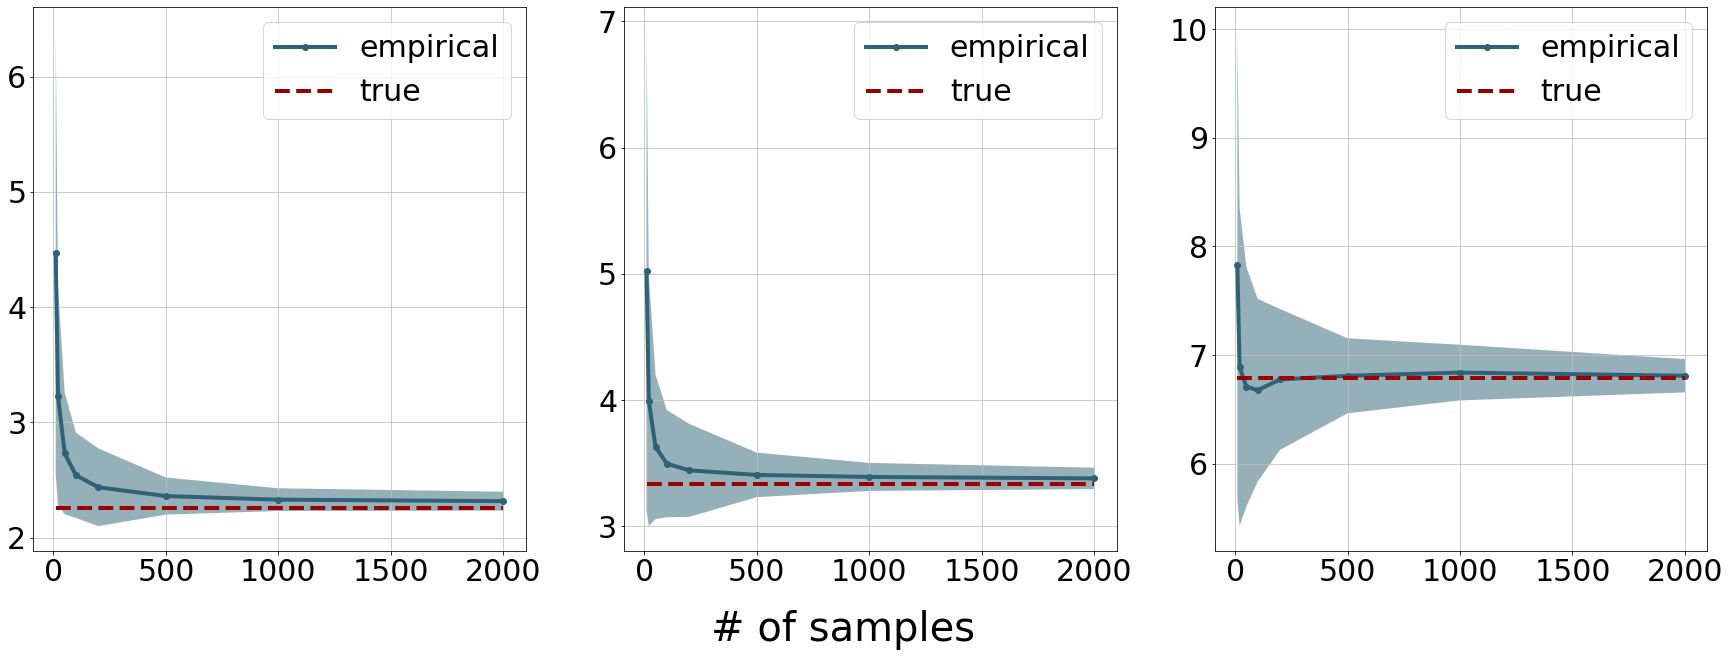

In [ ]:
list_epsilon = list(results.keys())

num_plot = len(list_epsilon)
plot_size = 10

color_background = "#FFFFFF"  # "#C0C0C0"
color_grid = "#C0C0C0"  # "#FFFFFF"

markersize = 12
linewidth = 4

legend_font_size = 30
text_size = 40
text_size_legend = 25
text_size_axis = 30

fig, axs = plt.subplots(1, num_plot, figsize=(plot_size * num_plot, plot_size), sharex='all')
plt.rcParams.update({'font.size': 44})

# axs[0].set_ylabel("value", size=text_size)

for i in range(num_plot):
    epsilon = list_epsilon[i]
    info = results[epsilon]
    
    axs[i].grid(True, color=color_grid)
    axs[i].set_facecolor(color_background)
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # axs[i].set_xscale('log')

    list_n = list(results[epsilon].keys())    
    list_empirical_mean = [info[n]['empirical_mean'] for n in list_n]
    list_empirical_std = [info[n]['empirical_std'] for n in list_n]
    true_value = info[list_n[0]]['true_value']

    lower_bound = (np.array(list_empirical_mean) - np.array(list_empirical_std)).tolist()
    upper_bound = (np.array(list_empirical_mean) + np.array(list_empirical_std)).tolist()

    list_n_numerical = [int(n) for n in list_n]

    axs[i].plot(list_n, list_empirical_mean,
                marker='.', markersize=markersize,
                color='#2F6276', linewidth=linewidth, linestyle='solid',
                label='empirical')
    axs[i].plot([list_n[0], list_n[-1]], [true_value, true_value],                
                color='#990000', linewidth=linewidth, linestyle='dashed',
                label='true')
    axs[i].fill_between(list_n, lower_bound, upper_bound, facecolor='#2F6276', alpha=0.5)

    axs[i].tick_params(axis='x', labelsize=text_size_axis)
    axs[i].tick_params(axis='y', labelsize=text_size_axis)
    axs[i].legend(prop={"size": legend_font_size}, loc="best")

fig.text(0.5, 0., '# of samples', ha='center', size=text_size)
plt.savefig(f'./convergence.pdf', bbox_inches='tight')
plt.show()

In [ ]:
save_object(results, './results_empirical_convergence.plk')

### Visualizing Transportation Plan

In [ ]:
set_seed(0)

dX = 1
dY = 1

n = 1000
sigmaX = 3.
sigmaY = 10.

X = np.linspace(-10, 10, n).reshape(-1, 1)
Y = np.linspace(-10, 10, n).reshape(-1, 1)

pos = np.empty(shape=(n, n, 2))
pos[:, :, 0], pos[:, :, 1] = np.meshgrid(X, Y)

CX = inner_product_distance(X, X)
CY = inner_product_distance(Y, Y)
CXY = inner_product_distance(X, Y)

# CX = CX / CX.max()
# CY = CY / CY.max()

CX_gpu = torch.from_numpy(CX).cuda()
CY_gpu = torch.from_numpy(CY).cuda()
CXY_gpu = torch.from_numpy(CXY).cuda()


pX = scipy.stats.norm.pdf(X, 0, np.sqrt(sigmaX))
pY = scipy.stats.norm.pdf(Y, 0, np.sqrt(sigmaY))
pX = pX / pX.sum()
pY = pY / pY.sum()
pX_gpu = torch.from_numpy(pX).cuda()
pY_gpu = torch.from_numpy(pY).cuda()

a = sigmaX * sigmaY
list_epsilon = [0.1, 1., a, 2 * a, 4 * a, 5 * a]
# list_epsilon = [a]
print(list_epsilon)

# ---
results = list()
results_cov_empr = list()
results_cov_theory = list()

for i in range(len(list_epsilon)):
    epsilon = list_epsilon[i]

    cov_mars = np.array([[sigmaX, 0], [0, sigmaY]])

    T, log = entropic_gromov_wasserstein(CX_gpu, CY_gpu, pX_gpu.reshape(-1,), pY_gpu.reshape(-1,), 
                                        'square_loss', max_iter=100, epsilon=epsilon, verbose=True, log=True)    
    T_empr = T.detach().cpu().numpy()

    T_empr = T_empr / T_empr.sum()
    T_empr = rounding(T_empr, pX, pY)

    a, b, c = fitgaussian((pos, T_empr))
    B = np.array([[a**2, 0], [b, c**2]])
    cov_empr = B @ B.T
    T_empr_continuous = scipy.stats.multivariate_normal.pdf(pos, np.zeros(2), cov_empr)
    T_empr_continuous = T_empr_continuous / T_empr_continuous.sum()

    results_cov_empr.append(cov_empr)
    print(cov_empr)

    print(f'gw_empr: {compute_igw(np.zeros(1), np.zeros(1), cov_empr, epsilon)}')

    # ---
    mean_theory, cov_theory = get_optimal_plan(np.array([[sigmaY]]), np.array([[sigmaX]]), epsilon=epsilon)    
    T_theory = scipy.stats.multivariate_normal.pdf(pos, mean_theory, cov_theory)
    T_theory = T_theory / T_theory.sum()
    print(cov_theory)
    results_cov_theory.append(cov_theory)

    print(np.linalg.norm(T_theory.sum(1).reshape(-1, 1) - pX))
    print(np.linalg.norm(T_theory.sum(0).reshape(-1, 1) - pY))

    true_value = compute_entropic_igw_formula(np.array([[sigmaY]]), np.array([[sigmaX]]), epsilon=epsilon)
    print(f'gw_theory: {true_value} = {compute_igw(np.zeros(1), np.zeros(1), cov_theory, epsilon)}')

    results.append([T_empr, T_empr_continuous, T_theory])

[0.1, 1.0, 30.0, 60.0, 120.0, 150.0]
It.  |Err         
-------------------
    0|3.275525e-03|


/usr/local/lib/python3.7/dist-packages/ot/bregman.py:723: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|1.552929e-14|
1
[[9.88105513 5.42561139]
 [5.42561139 2.98170664]]
gw_empr: 48.00461018969469
[[10.          5.47494292]
 [ 5.47494292  3.        ]]
0.00017349616129415485
3.875858746785516e-17
gw_theory: 49.40450384178881 = 49.40450384178881
It.  |Err         
-------------------
    0|2.318388e-03|
   10|7.844159e-16|
1
[[ 9.95965251 -5.44851043]
 [-5.44851043  3.00599106]]
gw_empr: 51.24615164510827
[[10.          5.45435606]
 [ 5.45435606  3.        ]]
0.0001609041054063444
3.2758055089074205e-17
gw_theory: 51.893745871391026 = 51.89374587139103
It.  |Err         
-------------------
    0|2.274735e-03|
   10|2.682427e-06|
   20|1.154052e-14|
1
[[9.9822952  4.73984855]
 [4.73984855 3.01062236]]
gw_empr: 84.42607068371217
[[10.          4.74341649]
 [ 4.74341649  3.        ]]
0.00012009734574588582
4.952829239943063e-14
gw_theory: 84.79441541679836 = 84.79441541679836
It.  |Err         
-------------------
    0|2.274120e-03|
   10|8.553611e-05|
   20|2.183261e-09|
   30|4.634

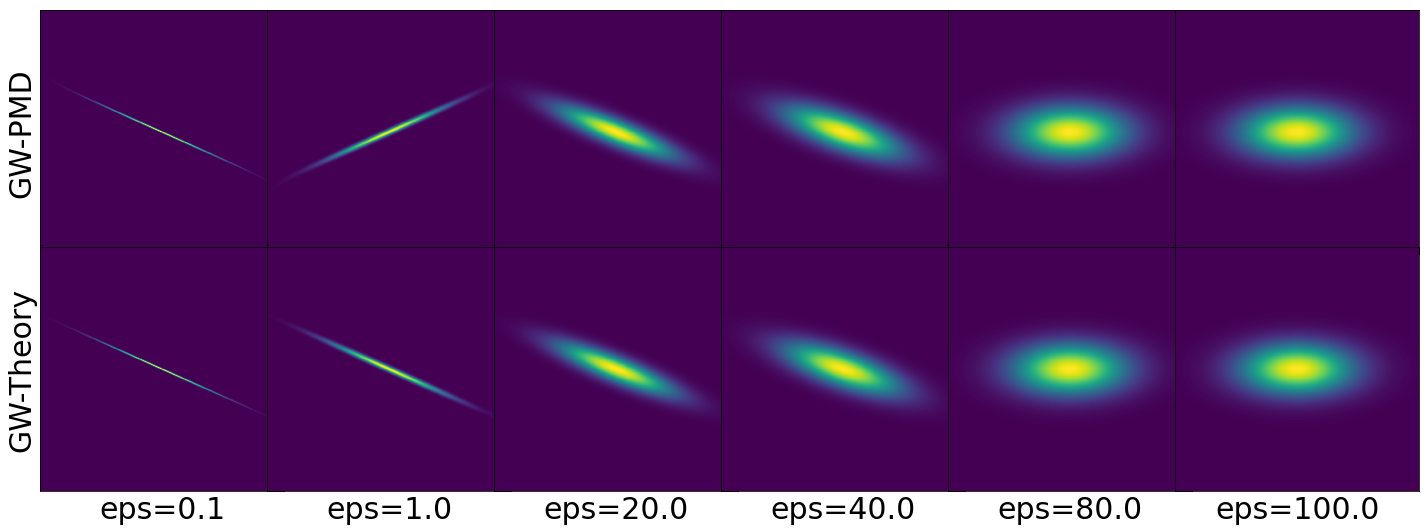

In [ ]:
num_plot = len(list_epsilon)
plot_size = 3

color_background = "#FFFFFF"  # "#C0C0C0"
color_grid = "#C0C0C0"  # "#FFFFFF"

markersize = 12
linewidth = 2

legend_font_size = 30
text_size = 40
text_size_legend = 25
text_size_axis = 30


fig, axs = plt.subplots(2, num_plot, figsize=(plot_size * num_plot, plot_size * 2), sharex='all')
plt.tight_layout(pad=-1.5)
plt.rcParams.update({'font.size': 44})

for i in range(num_plot):
    epsilon = list_epsilon[i]    
    # axs[i].contourf(*np.meshgrid(X, Y), T_cpu, cmap='viridis')
    axs[0][i].matshow(results[i][0])
    axs[1][i].matshow(results[i][2])

    axs[0][i].get_xaxis().set_ticks([])
    axs[1][i].get_xaxis().set_ticks([])    
    axs[0][i].get_yaxis().set_ticks([])
    axs[1][i].get_yaxis().set_ticks([])    

    axs[1][i].set_xlabel(f'eps={epsilon}', fontsize=30)

    if i == 0:
        axs[0][i].set_ylabel('GW-PMD', fontsize=30)        
        axs[1][i].set_ylabel('GW-Theory', fontsize=30)
    

# ---
# fig.text(0.5, 0., '# of samples', ha='center', size=text_size)
plt.savefig(f'./transportation_plan.pdf', bbox_inches='tight')
plt.show()

## Unbalanced IGW

### Empirical Convergence

In [ ]:
set_seed(42)

dX, dY = 3, 2
muX, muY = np.zeros(dX), np.zeros(dY)
mX, mY = 1, 1
diagX, diagY = np.random.rand(dX) * 2, np.random.rand(dY) * 2
SigmaX, SigmaY = np.diag(diagX), np.diag(diagY)
lambdaX, lambdaY = np.sort(diagX[::-1]), np.sort(diagY[::-1])

tau = 1

results = dict()
for epsilon in [0.5, 1., 5.]:
    results[epsilon] = dict()
    print(f'---> epsilon: {epsilon}')

    for n in [10, 20, 50, 100, 200, 500, 1000, 2000]:
        print(f'-> n: {n}')

        results[epsilon][n] = dict()
        empirical_values = list()
    
        for seed in range(20):
            set_seed(seed)            
    
            X = [np.random.multivariate_normal(mean=muX, cov=SigmaX) for _ in range(n)]
            Y = [np.random.multivariate_normal(mean=muY, cov=SigmaY) for _ in range(n)]
            X = np.array(X)
            Y = np.array(Y)

            CX = inner_product_distance(X, X)
            CY = inner_product_distance(Y, Y)

            CX_gpu = torch.from_numpy(CX).cuda()
            CY_gpu = torch.from_numpy(CY).cuda()

            pX, pY = ot.unif(n), ot.unif(n)
            pX_gpu = torch.from_numpy(pX).cuda()
            pY_gpu = torch.from_numpy(pY).cuda()

            pi, gamma = log_ugw_sinkhorn(pX_gpu, CX_gpu, pY_gpu, CY_gpu, init=None, eps=epsilon,
                                        rho=tau, rho2=tau,
                                        nits_plan=1000, tol_plan=1e-5,
                                        nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                                        two_outputs=True)
            cost = ugw_cost(pi, gamma, pX_gpu, CX_gpu, pY_gpu, CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
            empirical_values.append(cost)

            cost_pi = ugw_cost(pi, pi, pX_gpu, CX_gpu, pY_gpu, CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
            cost_gamma = ugw_cost(gamma, gamma, pX_gpu, CX_gpu, pY_gpu, CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
            print(f'Checking tightness: {cost} = {cost_pi} = {cost_gamma}')

        true_value = solve_uigw(mX, mY, lambdaX, lambdaY, tau, epsilon)[0]
        empirical_mean = np.mean(empirical_values)
        empirical_std = np.std(empirical_values)

        results[epsilon][n]['true_value'] = true_value
        results[epsilon][n]['empirical_mean'] = empirical_mean
        results[epsilon][n]['empirical_std'] = empirical_std

    print_dict(results)

---> epsilon: 0.5
-> n: 10
Checking tightness: 1.7873672338788285 = 1.7873672338788376 = 1.7873672338788544
Checking tightness: 1.7994361816715978 = 1.7994361816716582 = 1.7994361816717195
Checking tightness: 1.5833481702950118 = 1.5833481702950452 = 1.583348170295075
Checking tightness: 1.5770077187501639 = 1.6482517560730177 = 1.624441418160268
Checking tightness: 1.466463352389171 = 1.46646348069236 = 1.4664634820552103
Checking tightness: 1.462051200923648 = 2.1327486907470545 = 1.9564714015114795
Checking tightness: 1.670638073093637 = 1.6706380730937027 = 1.6706380730937518
Checking tightness: 1.8437890506151795 = 1.8437890506152086 = 1.8437890506152197
Checking tightness: 1.8968419717293057 = 3.5352808912220075 = 2.6149831612242553
Checking tightness: 1.4212430459613736 = 1.4212430459613887 = 1.4212430459613987
Checking tightness: 1.6255799601558456 = 1.822915185942323 = 1.7183634088960231
Checking tightness: 1.5185666170865848 = 1.5185666170865024 = 1.5185666170866268
Checking 

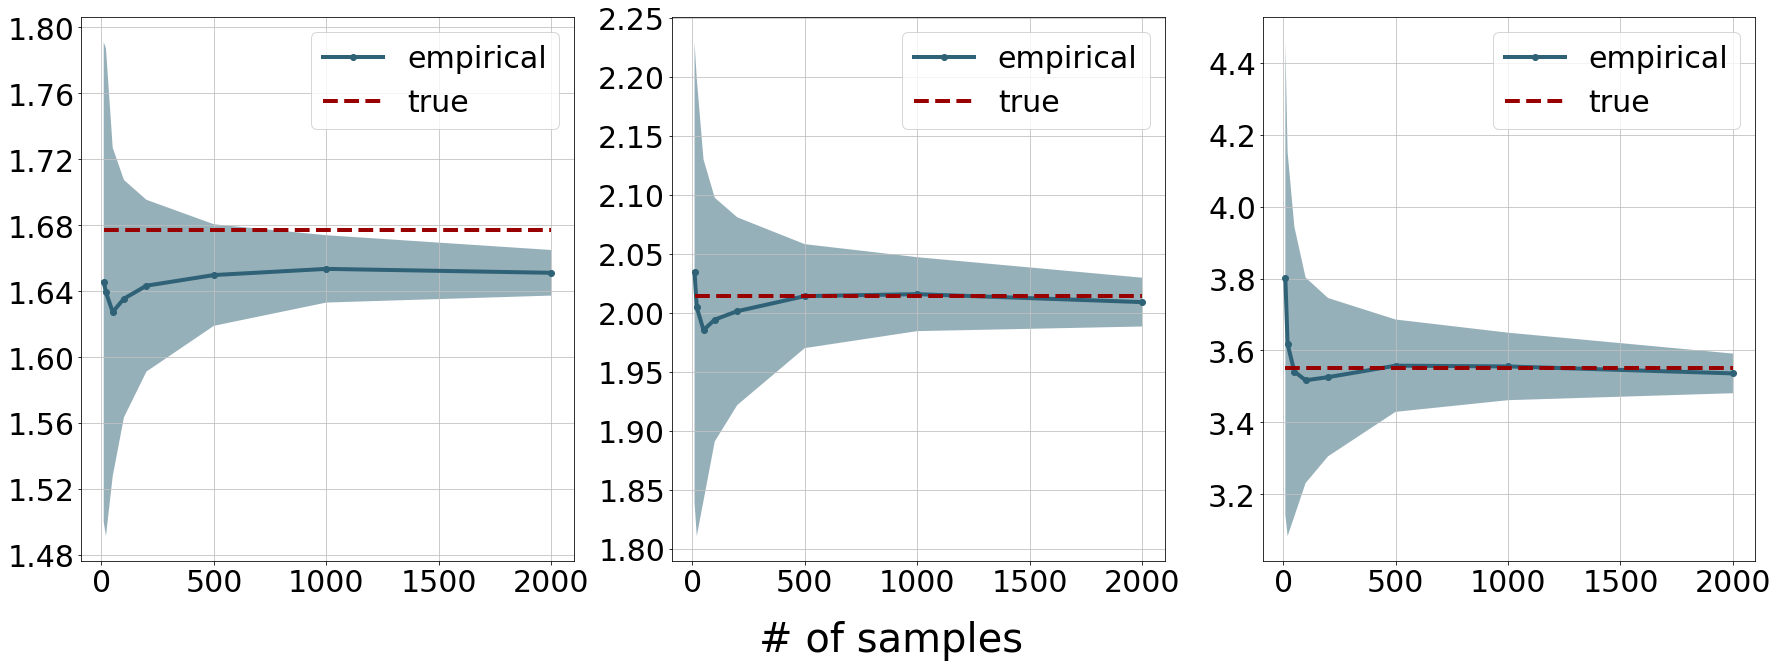

In [ ]:
list_epsilon = list(results.keys())

num_plot = len(list_epsilon)
plot_size = 10

color_background = "#FFFFFF"  # "#C0C0C0"
color_grid = "#C0C0C0"  # "#FFFFFF"

markersize = 12
linewidth = 4

legend_font_size = 30
text_size = 40
text_size_legend = 25
text_size_axis = 30

fig, axs = plt.subplots(1, num_plot, figsize=(plot_size * num_plot, plot_size), sharex='all')
plt.rcParams.update({'font.size': 44})

# axs[0].set_ylabel("value", size=text_size)

for i in range(num_plot):
    epsilon = list_epsilon[i]
    info = results[epsilon]
    
    axs[i].grid(True, color=color_grid)
    axs[i].set_facecolor(color_background)
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    # axs[i].set_xscale('log')

    list_n = list(results[epsilon].keys())    
    list_empirical_mean = [info[n]['empirical_mean'] for n in list_n]
    list_empirical_std = [info[n]['empirical_std'] for n in list_n]
    true_value = info[list_n[0]]['true_value']

    lower_bound = (np.array(list_empirical_mean) - np.array(list_empirical_std)).tolist()
    upper_bound = (np.array(list_empirical_mean) + np.array(list_empirical_std)).tolist()

    list_n_numerical = [int(n) for n in list_n]

    axs[i].plot(list_n, list_empirical_mean,
                marker='.', markersize=markersize,
                color='#2F6276', linewidth=linewidth, linestyle='solid',
                label='empirical')
    axs[i].plot([list_n[0], list_n[-1]], [true_value, true_value],                
                color='#990000', linewidth=linewidth, linestyle='dashed',
                label='true')
    axs[i].fill_between(list_n, lower_bound, upper_bound, facecolor='#2F6276', alpha=0.5)

    axs[i].tick_params(axis='x', labelsize=text_size_axis)
    axs[i].tick_params(axis='y', labelsize=text_size_axis)
    axs[i].legend(prop={"size": legend_font_size}, loc="best")

fig.text(0.5, 0., '# of samples', ha='center', size=text_size)
plt.savefig(f'./convergence.pdf', bbox_inches='tight')
plt.show()

In [ ]:
save_object(results, './results_empirical_convergence.plk')

### Visualizing Transportation Plan

#### Varying $\epsilon$

In [ ]:
set_seed(42)

mX, mY = 1, 1
tau = 1

dX = 1
dY = 1

nX, nY = 1000, 1000
sigmaX = 2.
sigmaY = 10.

X = np.linspace(-10, 10, nX).reshape(-1, 1)
Y = np.linspace(-10, 10, nY).reshape(-1, 1)

pos = np.empty(shape=(nY, nX, 2))
pos[:, :, 0], pos[:, :, 1] = np.meshgrid(X, Y)

CX = inner_product_distance(X, X)
CY = inner_product_distance(Y, Y)

CX_gpu = torch.from_numpy(CX).cuda()
CY_gpu = torch.from_numpy(CY).cuda()


pX = scipy.stats.norm.pdf(X, 0, np.sqrt(sigmaX))
pY = scipy.stats.norm.pdf(Y, 0, np.sqrt(sigmaY))
pX = pX / pX.sum()
pY = pY / pY.sum()
pX_gpu = torch.from_numpy(pX).cuda()
pY_gpu = torch.from_numpy(pY).cuda()

list_epsilon = [0.1, 1., 10., 20., 50., 100.]
print(list_epsilon)

# ---
results = list()

for i in range(len(list_epsilon)):
    epsilon = list_epsilon[i]    

    """ --- """
    pi, gamma = log_ugw_sinkhorn(pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, init=None, eps=epsilon,
                                 rho=tau, rho2=tau,
                                 nits_plan=5000, tol_plan=1e-5,
                                 nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                                 two_outputs=True)        
    cost = ugw_cost(pi, gamma, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    cost_pi = ugw_cost(pi, pi, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    cost_gamma = ugw_cost(gamma, gamma, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    print(f'Checking tightness: {cost} = {cost_pi} = {cost_gamma}')    
    
    T_empr = pi.detach().cpu().numpy()

    T_empr = T_empr / T_empr.sum()
    T_uigw_empr = rounding(T_empr, pX, pY)

    """ --- """
    mean_theory, cov_theory = solve_uigw(mY, mX, np.array([sigmaY]), np.array([sigmaX]), tau, epsilon)[1]
    T_theory = scipy.stats.multivariate_normal.pdf(pos, mean_theory, cov_theory)
    T_theory = T_theory / T_theory.sum()        
    results.append([T_uigw_empr, T_theory])

    print(cov_theory)

[0.1, 1.0, 10.0, 20.0, 50.0, 100.0]
Checking tightness: 1.664145092266707 = 1.664145092266708 = 1.664145092266708
[[3.08479154 3.0225159 ]
 [3.0225159  2.97770603]]
Checking tightness: 2.445641957641389 = 2.4456419576413917 = 2.445641957641392
[[1.76346999 1.51200972]
 [1.51200972 1.57993808]]
Checking tightness: 8.68113607462693 = 8.681136074626998 = 8.681136074627046
[[2.08627614 0.        ]
 [0.         1.3435704 ]]
Checking tightness: 14.057190156197999 = 14.05719015619826 = 14.057190156198578
[[2.75762471 0.        ]
 [0.         1.54520683]]
Checking tightness: 25.705587021716674 = 25.7055870217175 = 25.705587021720568
[[3.93322667 0.        ]
 [0.         1.75768867]]
Checking tightness: 38.23397254372476 = 38.2339725437247 = 38.23397254373877
[[5.016593   0.        ]
 [0.         1.86260246]]


In [ ]:
set_seed(42)

mX, mY = 1, 1
tau = 1

dX = 1
dY = 1

nX, nY = 1000, 1000
sigmaX = 2.
sigmaY = 10.

X = np.linspace(-10, 10, nX).reshape(-1, 1)
Y = np.linspace(-10, 10, nY).reshape(-1, 1)

pos = np.empty(shape=(nY, nX, 2))
pos[:, :, 0], pos[:, :, 1] = np.meshgrid(X, Y)

CX = inner_product_distance(X, X)
CY = inner_product_distance(Y, Y)

CX_gpu = torch.from_numpy(CX).cuda()
CY_gpu = torch.from_numpy(CY).cuda()


pX = scipy.stats.norm.pdf(X, 0, np.sqrt(sigmaX))
pY = scipy.stats.norm.pdf(Y, 0, np.sqrt(sigmaY))
pX = pX / pX.sum()
pY = pY / pY.sum()
pX_gpu = torch.from_numpy(pX).cuda()
pY_gpu = torch.from_numpy(pY).cuda()

list_epsilon = [0.1, 1., 10., 20., 50., 100.]
print(list_epsilon)

# ---
results = list()

for i in range(len(list_epsilon)):
    epsilon = list_epsilon[i]    

    """ --- """
    pi, gamma = log_ugw_sinkhorn(pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, init=None, eps=epsilon,
                                 rho=tau, rho2=tau,
                                 nits_plan=5000, tol_plan=1e-5,
                                 nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                                 two_outputs=True)        
    cost = ugw_cost(pi, gamma, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    cost_pi = ugw_cost(pi, pi, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    cost_gamma = ugw_cost(gamma, gamma, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    print(f'Checking tightness: {cost} = {cost_pi} = {cost_gamma}')    
    
    T_empr = pi.detach().cpu().numpy()

    T_empr = T_empr / T_empr.sum()
    T_uigw_empr = rounding(T_empr, pX, pY)

    """ --- """
    mean_theory, cov_theory = solve_uigw(mY, mX, np.array([sigmaY]), np.array([sigmaX]), tau, epsilon)[1]
    T_theory = scipy.stats.multivariate_normal.pdf(pos, mean_theory, cov_theory)
    T_theory = T_theory / T_theory.sum()        
    results.append([T_uigw_empr, T_theory])

    print(cov_theory)

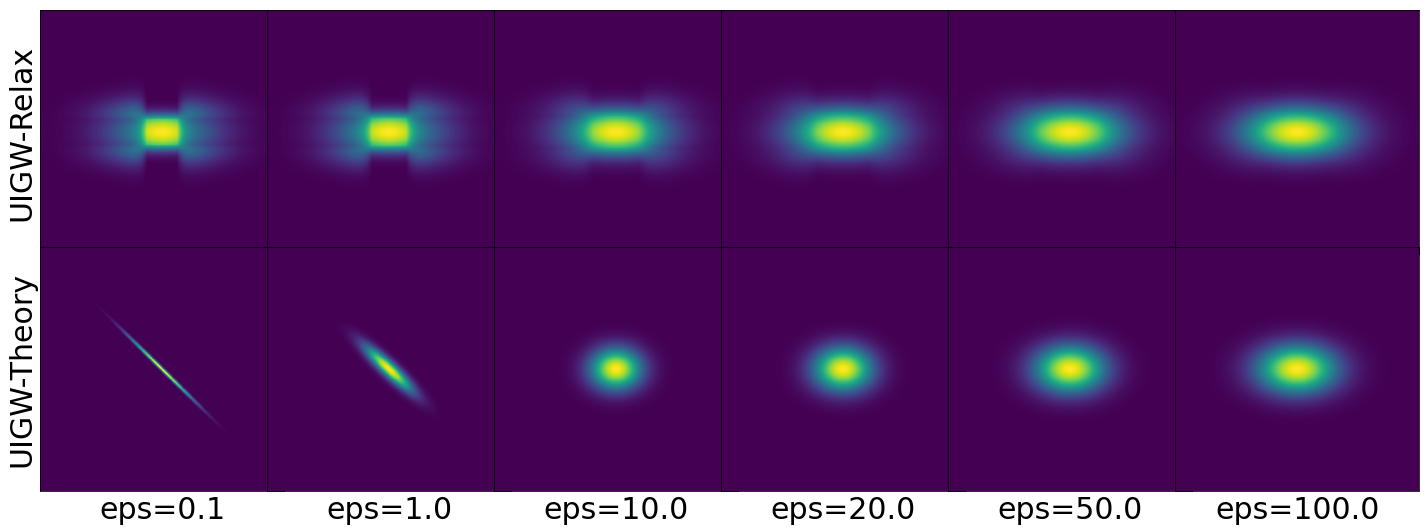

In [ ]:
num_plot = len(list_epsilon)
plot_size = 3

color_background = "#FFFFFF"  # "#C0C0C0"
color_grid = "#C0C0C0"  # "#FFFFFF"

markersize = 12
linewidth = 2

legend_font_size = 30
text_size = 40
text_size_legend = 25
text_size_axis = 30


fig, axs = plt.subplots(2, num_plot, figsize=(plot_size * num_plot, plot_size * 2), sharex='all')
plt.tight_layout(pad=-1.5)
plt.rcParams.update({'font.size': 44})

for i in range(num_plot):
    epsilon = list_epsilon[i]    
    # axs[i].contourf(*np.meshgrid(X, Y), T_cpu, cmap='viridis')
    axs[0][i].matshow(results[i][0])
    axs[1][i].matshow(results[i][1])    

    axs[0][i].get_xaxis().set_ticks([])
    axs[1][i].get_xaxis().set_ticks([])    
    axs[0][i].get_yaxis().set_ticks([])
    axs[1][i].get_yaxis().set_ticks([])    

    axs[1][i].set_xlabel(f'eps={epsilon}', fontsize=30)

    if i == 0:        
        axs[0][i].set_ylabel('UIGW-Relax', fontsize=30)
        axs[][i].set_ylabel('UIGW-Theory', fontsize=30)
    

# ---
# fig.text(0.5, 0., '# of samples', ha='center', size=text_size)
plt.savefig(f'./transportation_plan.pdf', bbox_inches='tight')
plt.show()

#### Varying $\tau$

In [ ]:
set_seed(42)

mX, mY = 1, 1

dX = 1
dY = 1

nX, nY = 1000, 1000
sigmaX = 3.
sigmaY = 10.

X = np.linspace(-10, 10, nX).reshape(-1, 1)
Y = np.linspace(-10, 10, nY).reshape(-1, 1)

pos = np.empty(shape=(nY, nX, 2))
pos[:, :, 0], pos[:, :, 1] = np.meshgrid(X, Y)

CX = inner_product_distance(X, X)
CY = inner_product_distance(Y, Y)

CX_gpu = torch.from_numpy(CX).cuda()
CY_gpu = torch.from_numpy(CY).cuda()


pX = scipy.stats.norm.pdf(X, 0, np.sqrt(sigmaX))
pY = scipy.stats.norm.pdf(Y, 0, np.sqrt(sigmaY))
pX = pX / pX.sum()
pY = pY / pY.sum()
pX_gpu = torch.from_numpy(pX).cuda()
pY_gpu = torch.from_numpy(pY).cuda()

epsilon = sigmaX * sigmaY
list_tau = [0.01, 0.1, 1, 10, 100, 1e5]

print(list_tau)

# ---
results = list()

for i in range(len(list_tau)):
    tau = list_tau[i]

    cov_mars = np.array([[sigmaX, 0], [0, sigmaY]])

    """ --- """
    T, log = entropic_gromov_wasserstein(CX_gpu, CY_gpu, pX_gpu.reshape(-1,), pY_gpu.reshape(-1,), 
                                        'square_loss', max_iter=100, epsilon=epsilon, verbose=True, log=True)        
    T_empr = T.detach().cpu().numpy()

    T_empr = T_empr / T_empr.sum()
    T_igw_empr = rounding(T_empr, pX, pY)    

    """ --- """
    pi, gamma = log_ugw_sinkhorn(pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, init=None, eps=epsilon,
                            rho=tau, rho2=tau,
                            nits_plan=1000, tol_plan=1e-5,
                            nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                            two_outputs=True)
    cost = ugw_cost(pi, gamma, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    cost_pi = ugw_cost(pi, pi, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    cost_gamma = ugw_cost(gamma, gamma, pX_gpu.reshape(-1,), CX_gpu, pY_gpu.reshape(-1,), CY_gpu, eps=epsilon, rho=tau, rho2=tau).item()
    print(f'Checking tightness: {cost} = {cost_pi} = {cost_gamma}')    

    T_empr = pi.detach().cpu().numpy()

    T_empr = T_empr / T_empr.sum()
    T_uigw_empr = rounding(T_empr, pX, pY)

    """ --- """
    mean_theory, cov_theory = solve_uigw(mY, mX, np.array([sigmaY]), np.array([sigmaX]), tau, epsilon)[1]
    T_theory = scipy.stats.multivariate_normal.pdf(pos, mean_theory, cov_theory)
    T_theory = T_theory / T_theory.sum()            
    print(cov_theory)

    results.append([T_igw_empr, T_uigw_empr, T_theory])

[0.01, 0.1, 1, 10, 100, 100000.0]
It.  |Err         
-------------------
    0|2.275177e-03|
   10|2.514248e-08|
   20|1.087246e-16|
Checking tightness: 18.985431739272073 = 18.985431739272396 = 18.985431739272965
[[3.19536466 0.        ]
 [0.         2.10993313]]
It.  |Err         
-------------------
    0|2.274907e-03|
   10|1.206150e-07|
   20|5.180499e-16|
Checking tightness: 19.049880883751275 = 19.04988088375159 = 19.049880883752145
[[3.19924091 0.        ]
 [0.         2.11137836]]
It.  |Err         
-------------------
    0|2.273574e-03|
   10|5.125832e-08|
   20|2.204844e-16|
Checking tightness: 19.68096366821487 = 19.68096366821532 = 19.68096366821615
[[3.23755841 0.        ]
 [0.         2.12555306]]
It.  |Err         
-------------------
    0|2.275377e-03|
   10|7.583627e-08|
   20|3.257508e-16|
Checking tightness: 25.006789533520358 = 25.00678953352068 = 25.006789533521502
[[3.58257569 0.        ]
 [0.         2.24440018]]
It.  |Err         
-------------------
    0|2.

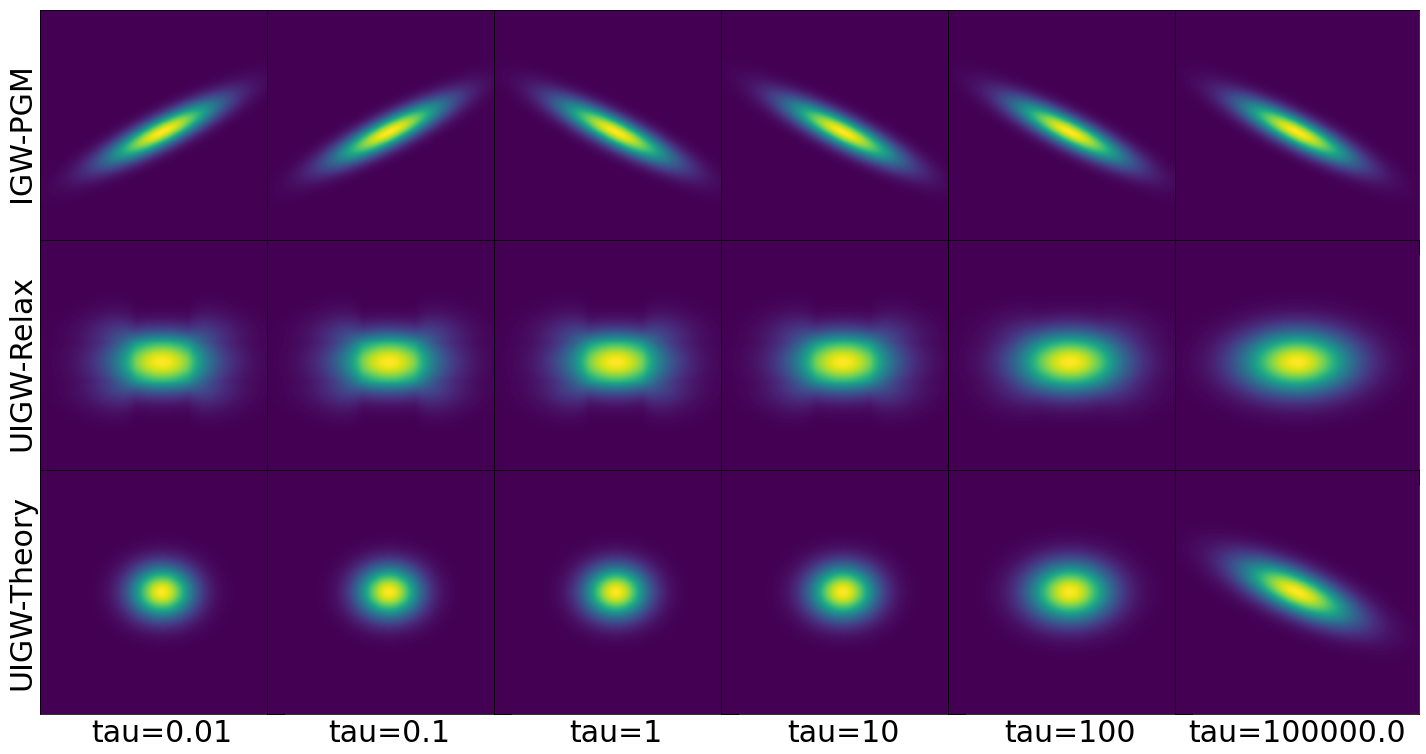

In [ ]:
num_plot = len(list_tau)
plot_size = 3

color_background = "#FFFFFF"  # "#C0C0C0"
color_grid = "#C0C0C0"  # "#FFFFFF"

markersize = 12
linewidth = 2

legend_font_size = 30
text_size = 40
text_size_legend = 25
text_size_axis = 30


fig, axs = plt.subplots(3, num_plot, figsize=(plot_size * num_plot, plot_size * 3), sharex='all')
plt.tight_layout(pad=-1.5)
plt.rcParams.update({'font.size': 44})

for i in range(num_plot):
    tau = list_tau[i]    
    # axs[i].contourf(*np.meshgrid(X, Y), T_cpu, cmap='viridis')
    axs[0][i].matshow(results[i][0])
    axs[1][i].matshow(results[i][1])
    axs[2][i].matshow(results[i][2])

    axs[0][i].get_xaxis().set_ticks([])
    axs[1][i].get_xaxis().set_ticks([])
    axs[2][i].get_xaxis().set_ticks([])    
    axs[0][i].get_yaxis().set_ticks([])
    axs[1][i].get_yaxis().set_ticks([])
    axs[2][i].get_yaxis().set_ticks([])

    axs[2][i].set_xlabel(f'tau={tau}', fontsize=30)

    if i == 0:
        axs[0][i].set_ylabel('IGW-PGM', fontsize=30)
        axs[1][i].set_ylabel('UIGW-Relax', fontsize=30)
        axs[2][i].set_ylabel('UIGW-Theory', fontsize=30)
    

# ---
# fig.text(0.5, 0., '# of samples', ha='center', size=text_size)
plt.savefig(f'./transportation_plan.pdf', bbox_inches='tight')
plt.show()

## Barycenter

In [ ]:
set_seed(3)

n = 1000  

list_d = [1, 2, 3]
d_bc = 2
list_weight = [0.3, 0.6, 0.1]
# list_scale = [2, 10]

m = len(list_d)

list_dl = [min(d_bc, d) for d in list_d]
list_mu = [np.zeros(d) for d in list_d]

list_diag = [np.array([5]), np.array([10, 1]), np.array([2, 1, 1])]
print(list_diag)

list_Sigma = [np.diag(vec) for vec in list_diag]  

list_A = [sum([list_weight[l] * list_diag[l][j] for l in range(m) if j < list_dl[l]]) for j in range(d_bc)]
list_B = [sum([list_weight[l] for l in range(m) if j < list_dl[l]]) for j in range(d_bc)]
upper_epsilon = min([list_A[i]**2 / list_B[i] for i in range(d_bc)])

epsilon = upper_epsilon
while True:
    for l in range(m):
        for j in range(d_bc):
            if list_A[j] - epsilon * list_B[j] < 0:
                epsilon *= 0.99
                continue

            if j < list_dl[l]:
                if epsilon > 2 * list_diag[l][j] * np.sqrt(list_A[j] - epsilon * list_B[j]):
                    epsilon *= 0.99
                    continue
    
    break
epsilon = min(epsilon, 0.1)
print(f'epsilon: {epsilon}')

# --- Closed form ---
vec_bc = [sum([list_weight[l] \
               * list_diag[l][j] \
               * (1 - epsilon / (list_diag[l][j] * (list_A[j] + np.sqrt(list_A[j]**2 - epsilon * list_B[j]))))
                    for l in range(m) if j < list_dl[l]]) for j in range(d_bc)]
Sigma_bc = np.diag(vec_bc)
print(vec_bc)

[array([5]), array([10,  1]), array([2, 1, 1])]
epsilon: 0.1
[7.6935037531673425, 0.648074069840786]


In [ ]:
list_X = [[np.random.multivariate_normal(mean=list_mu[i], cov=list_Sigma[i]) for _ in range(n)] for i in range(m)]
list_X = [np.array(X) for X in list_X]

list_C = [inner_product_distance(X, X) for X in list_X]
list_C_gpu = [torch.from_numpy(C).cuda() for C in list_C]            

list_p = [ot.unif(n) for _ in range(m)]
list_p_gpu = [torch.from_numpy(p).cuda() for p in list_p]

p = torch.from_numpy(ot.unif(n)).cuda()

C, log = entropic_gromov_barycenters(n, list_C_gpu, list_p_gpu, p, list_weight, 'square_loss', epsilon,
                                        max_iter=20, verbose=True, log=True)

print(C.shape)

It.  |Err         
-------------------
    0|1.338790e-04|
   10|3.088740e-03|
It.  |Err         
-------------------
    0|8.111424e-04|
   10|3.683640e-03|
It.  |Err         
-------------------
    0|2.344806e-04|
   10|2.270165e-03|
It.  |Err         
-------------------
    0|6.944507e+03|
It.  |Err         
-------------------
    0|8.838826e-04|


/usr/local/lib/python3.7/dist-packages/ot/bregman.py:723: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|3.270353e-07|
It.  |Err         
-------------------
    0|2.024690e-03|
   10|1.072317e-05|
It.  |Err         
-------------------
    0|1.170471e-03|
   10|1.049413e-04|
It.  |Err         
-------------------
    0|1.314867e-03|
   10|2.426099e-05|
It.  |Err         
-------------------
    0|2.396437e-03|
   10|5.889875e-03|
It.  |Err         
-------------------
    0|1.646933e-03|
   10|2.270104e-03|
It.  |Err         
-------------------
    0|9.179912e-04|
   10|2.665893e-05|
It.  |Err         
-------------------
    0|1.947628e-03|
   10|2.587326e-05|
It.  |Err         
-------------------
    0|1.153499e-03|
   10|2.476560e-03|
It.  |Err         
-------------------
    0|1.009615e-03|
   10|1.662152e-05|
It.  |Err         
-------------------
    0|2.182579e-03|
   10|2.829823e-05|
It.  |Err         
-------------------
    0|1.317434e-03|
   10|2.332048e-03|
It.  |Err         
-------------------
    0|1.010827e-03|
   10|4.458474e-05|
It.  |Err         
-------------

In [ ]:
C = C.detach().cpu().numpy()
print(np.amin(C), np.amax(C))
barycenter = np.linalg.cholesky(C + 1e-10 * np.eye(n))

-97.77936967861055 110.15433328735092


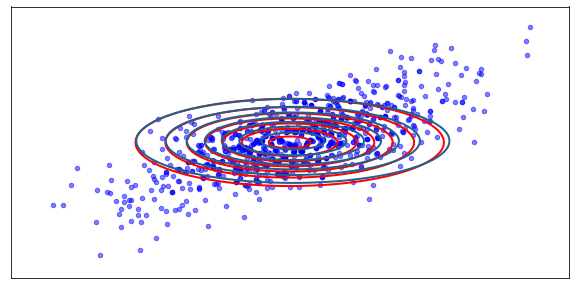

In [ ]:
plt.figure(1, (10, 5))
x = barycenter[:, 0]
y = barycenter[:, 1]
data_raw = np.array([x, y])
mean_raw = np.mean(data_raw, axis=-1)
Sigma_raw = np.cov(data_raw)
R = np.array(np.linalg.eig(Sigma_raw)[1])
Sigma_empr_diagonalized = np.diag(np.linalg.svd(Sigma_raw)[1])

n = 100
r = 10
pos = np.empty(shape=(n, n, 2))
X, Y = np.linspace(-r, r, n).reshape(-1, 1), np.linspace(-5, 5, n).reshape(-1, 1)
pos[:, :, 0], pos[:, :, 1] = np.meshgrid(X, Y)
T_theory = scipy.stats.multivariate_normal.pdf(pos, np.zeros(2), Sigma_bc)
T_theory = T_theory / np.sum(T_theory)

T_empr = scipy.stats.multivariate_normal.pdf(pos, mean_raw, Sigma_raw)
T_empr = T_empr / np.sum(T_empr)

T_empr_transformed = scipy.stats.multivariate_normal.pdf(pos, mean_raw, Sigma_empr_diagonalized)
T_empr_transformed = T_empr_transformed / np.sum(T_empr_transformed)


plt.contour(*np.meshgrid(X, Y), T_theory, colors=('r'), linewidths=2)
plt.scatter(*data_raw, c='b', s=20., alpha=0.5)
plt.contour(*np.meshgrid(X, Y), T_empr_transformed, colors=('#21618C'), linewidths=2)
plt.xticks([])
plt.yticks([])

plt.savefig(f'./barycenter.pdf', bbox_inches='tight')

plt.show()

In [ ]:
results = {
    'barycenter': barycenter,
    'Sigma_bc': Sigma_bc
}

In [ ]:
save_object(results, './results_barycenter.plk')